In [1]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
import math

In [2]:
class Multi_Layer_Perceptron(nn.Sequential):
    def __init__(self, input_dim, intern_dim, output_dim, depth = 2, isBiased = False):
        
        dict = OrderedDict([("input",nn.Linear(input_dim,intern_dim, bias=isBiased))])
        for i in range(depth):
            dict.update({str(i) : nn.Linear(intern_dim,intern_dim,bias=isBiased)})
        dict.update({"output" : nn.Linear(intern_dim,output_dim,bias=isBiased)})

        super().__init__(dict)

        self.reset_init_weights_biases() # so that we do not use a default initialization

    def reset_init_weights_biases(self, norm = None):
        for layer in self.children():
            if norm == None:
                stdv = 1. / math.sqrt(layer.weight.size(1))
            else :
                stdv = norm
            
            layer.weight.data.uniform_(-stdv, stdv)
            if layer.bias is not None:
                layer.biases.data.uniform_(-stdv, stdv)

In [3]:
def train(model, input_data, output_data, lossFct = nn.MSELoss(), optimizer = None, epochs = 20, init_norm = None, save = True, debug = False, savename='model.pt'):

    if optimizer is None:
        optimizer = torch.optim.SGD(model.parameters())
    
    if init_norm is not None:
        model.reset_init_weights_biases(init_norm)

    for i in range(epochs):
        y_pred = model(input_data)
        loss = lossFct(y_pred, output_data)

        if math.isnan(loss.item()):
            print(f"Epoch: {i+1}   Loss: {loss.item()}")
            break
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if debug:
            if (i+1)%(epochs/debug) == 0:
                print(f"Epoch: {i+1}   Loss: {loss.item()}")
        
        if save:
            torch.save(model.state_dict(), DIRPATH+savename)
    

In [4]:
def Generate_data(p = 100, n = 500, sigma2 = 2):
        ### Data generation
    data = np.random.multivariate_normal(
        np.zeros(p),
        np.ones((p,p)),
        size=n) # shape (n,p)

    w_true = np.ones(p)*1/np.sqrt(p)

    observations = [np.random.normal(
        np.dot(w_true, x),
        sigma2)
        for x in data]
    observations = np.array(observations) # shape (n,)

    return data, observations
    

In [5]:
def Ridge_Lambda_Compute(A,b,LambdaArray):
    error = np.zeros((LambdaArray.shape[0]))
    for i in range(LambdaArray.shape[0]):
        res = ridge(A,b,LambdaArray[i])
        error[i] = objective(A,b,res)
    ridgeErrorArray = np.hstack((LambdaArray[:,np.newaxis],error[:,np.newaxis]))
    return ridgeErrorArray

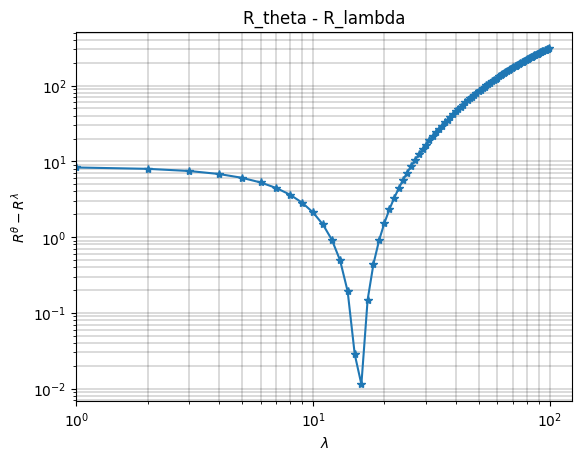

In [6]:
%run utils.py
%run Plot_lib.ipynb

A,b = Generate_data()
LambdaArray = np.arange(100)
ridgeErrorArray = Ridge_Lambda_Compute(A,b,LambdaArray)

plot_MvsR_overLambda(5,ridgeErrorArray)